# Total RMSE for performance assessment of ARPEGE-Climat PPE

<a id="top">This code</a> is combining the metric of four different variables (tas, pr, SW, LW) to create an aggretated metric $E_{tot}$ used for performance assessment and seleciton of an optimal sub-set of parametrizations. 

### [Step 1 - Emulator skill evaluation](#skill)
### [Step 2 - Initial guess for optimization 1 ](#init1)
### [Step 3 - Optimisation 1 ](#optim1)
### [Step 4 - Initial guess for Optimization 2 (param. smoothing)](#init2)
### [Step 5 - Optimisation 2](#optim2)
### [Step 6 - Optimal subset of parameters](#selection)
### [Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3](#validation)

## Importe modules

In [3]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

## Functions

In [4]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

# FONCTION MOYENNE NORMALISEE DES VARIABLES

def Norm_Average_df(Fdbck, variables, E_p1_df, name) :

    E_df = pd.DataFrame()
    E_df['Fdbck'] = Fdbck

    tmp = [0]*len(E_df) 

    for i in variables :
        E = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'+name+'_'+i+'.npy')
        E_df['RMSE_'+i] = E

        E_df['RMSE_'+i+'_norm'] = E_df['RMSE_'+i]/E_p1_df['E_p1_'+i]

        tmp = tmp + E_df['RMSE_'+i+'_norm']
    
    E_df['RMSE_total'] = tmp/len(variables)
    return E_df

In [5]:
def MultiLinReg_RMSE_skill_eval(limit_train, x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def function_RMSE_emulator_std_skill_eval(limit_train, x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_RMSE_skill_eval(limit_train,x, 1, variable)
    pc2 = MultiLinReg_RMSE_skill_eval(limit_train,x, 2, variable)
    pc3 = MultiLinReg_RMSE_skill_eval(limit_train,x, 3, variable)
    pc4 = MultiLinReg_RMSE_skill_eval(limit_train,x, 4, variable)
    pc5 = MultiLinReg_RMSE_skill_eval(limit_train,x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_total_skill_eval(limit_train, x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator_std_skill_eval(limit_train, x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E

In [6]:
# FONCTIONS FEEDBACKS

def em_fdb_std_skill_eval(limit_train, x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [7]:
# FUNCTIONS EMULATORS

def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

# FONCTIONS ERROR

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable =='tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

def function_RMSE_total(x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator(x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E    

In [8]:
# FONCTION JACOBIAN OPTIM

def jacobian(x, variable) :
    
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1_'+variable+'.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2_'+variable+'.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3_'+variable+'.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4_'+variable+'.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5_'+variable+'.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1_'+variable+'.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2_'+variable+'.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3_'+variable+'.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4_'+variable+'.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5_'+variable+'.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac

# FONCTION JACOBIAN OF TOTAL ERROR

def jacobian_total(x, variables, E_p1_df) :
    
    tmp = 0
    for i in variables : 
        tmp0 = jacobian(x, i)/E_p1_df['E_p1_'+i]
        tmp = tmp + tmp0
    
    jac = tmp/len(variables)
    
    return jac

In [9]:
# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta_fdb.npy', Coeffs)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [10]:
# FONCTION N

def em_N_std(x) :
    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/TOA_budget_N.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]
    
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta_N.npy', Coeffs)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_N(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_N_std(x_std)
    return y_pred

In [11]:
# FONCTION JACOBIAN OPTIM

def jacobian_fdb(x, fdb_low, fdb_hi) :
    Beta = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta_fdb.npy')
    return Beta

def jacobian_N(x) :
    Beta = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta_N.npy')
    return Beta

In [12]:

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test
    
def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test
    
def constraint3(x):
    tmp_N = em_N(x)
    tmp_abs = abs(tmp_N)
    test = (2.0-tmp_abs)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variables, E_p1_df) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_N=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        N_x0 = em_N(x0)
        #print('N_x0 = '+str(N_x0))
        fun_x0 = function_RMSE_total(x0, variables, E_p1_df)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
        cons3 = {'type': 'ineq', 'fun' : constraint3}
        
    
        sol = minimize(function_RMSE_total,  x0, args=(variables, E_p1_df), method='SLSQP', bounds=xlim, 
                       constraints=(cons1, cons2, cons3), 
                   jac = jacobian_total, options={'disp': True}, tol = 0.0001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_total(sol.x, variables, E_p1_df)
        tmp_fdbck = em_fdb(sol.x)
        tmp_N = em_N(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_N.append(tmp_N)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    sol_df['budget_N'] = sol_N[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [13]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

## Settings

In [14]:
variables = ['tas', 'pr', 'SW', 'LW']

variable_plot = 'total'
TITLE = 'Total'
ylabel = '$E_{tot}$ (no units)'

product = 'BEST'

## Get the data

### p1 default

In [15]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df = {}

for i in variables :
    E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+i+'.npy')
    E_p1_df['E_p1_'+i] = E_p1

E_p1_df

{'E_p1_tas': array(2.08017959),
 'E_p1_pr': array(1.99925075),
 'E_p1_SW': array(1.664249),
 'E_p1_LW': array(1.00782632)}

In [16]:
p1_feedbacks

array(-1.3328964)

In [17]:
E_p1_tmp = E_p1_df['E_p1_tas']/E_p1_df['E_p1_tas'] + E_p1_df['E_p1_pr']/E_p1_df['E_p1_pr'] + E_p1_df['E_p1_SW']/E_p1_df['E_p1_SW']+E_p1_df['E_p1_LW']/E_p1_df['E_p1_LW']
E_p1 = E_p1_tmp/4
E_p1

1.0

### CFMIP

In [18]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [19]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

MRI = {}
CAN = {}
MIROC = {}
HadGEM3 = {}
IPSL = {}
BCC = {}

for i in variables :
    
    if i == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'.npy')
    
    filename = 'U_MRI_'+i+'.npy'
    MRI[i] = Error(path, filename, U_obs)

    filename = 'U_CAN_'+i+'.npy'
    CAN[i] = Error(path, filename, U_obs)

    filename = 'U_MIROC_'+i+'.npy'
    MIROC[i] = Error(path, filename, U_obs)

    filename = 'U_HadGEM3_'+i+'.npy'
    HadGEM3[i] = Error(path, filename, U_obs)

    filename = 'U_IPSL_'+i+'.npy'
    IPSL[i] = Error(path, filename, U_obs)

    filename = 'U_BCC_'+i+'.npy'
    BCC[i] = Error(path, filename, U_obs)
    

E_MRI_tmp = MRI['tas']/E_p1_df['E_p1_tas'] + MRI['pr']/E_p1_df['E_p1_pr'] + MRI['SW']/E_p1_df['E_p1_SW']+MRI['LW']/E_p1_df['E_p1_LW']
E_MRI = E_MRI_tmp/4

E_CAN_tmp = CAN['tas']/E_p1_df['E_p1_tas'] + CAN['pr']/E_p1_df['E_p1_pr'] + CAN['SW']/E_p1_df['E_p1_SW']+CAN['LW']/E_p1_df['E_p1_LW']
E_CAN = E_CAN_tmp/4

E_MIROC_tmp = MIROC['tas']/E_p1_df['E_p1_tas'] + MIROC['pr']/E_p1_df['E_p1_pr'] + MIROC['SW']/E_p1_df['E_p1_SW']+MIROC['LW']/E_p1_df['E_p1_LW']
E_MIROC = E_MIROC_tmp/4

E_HadGEM3_tmp = HadGEM3['tas']/E_p1_df['E_p1_tas'] + HadGEM3['pr']/E_p1_df['E_p1_pr'] + HadGEM3['SW']/E_p1_df['E_p1_SW']+HadGEM3['LW']/E_p1_df['E_p1_LW']
E_HadGEM3 = E_HadGEM3_tmp/4

E_IPSL_tmp = IPSL['tas']/E_p1_df['E_p1_tas'] + IPSL['pr']/E_p1_df['E_p1_pr'] + IPSL['SW']/E_p1_df['E_p1_SW']+IPSL['LW']/E_p1_df['E_p1_LW']
E_IPSL = E_IPSL_tmp/4

E_BCC_tmp = BCC['tas']/E_p1_df['E_p1_tas'] + BCC['pr']/E_p1_df['E_p1_pr'] + BCC['SW']/E_p1_df['E_p1_SW']+BCC['LW']/E_p1_df['E_p1_LW']
E_BCC = E_BCC_tmp/4

In [20]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

### PPE

In [21]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
N_PPE = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/TOA_budget_N.npy')

name = 'RMSE_PPE'
E_PPE_df = Norm_Average_df(Fdbck_PPE, variables, E_p1_df, name) 
E_PPE_df['budget_N']=N_PPE
E_PPE_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,budget_N
0,-0.825236,1.055966,0.507632,3.017001,1.509066,1.277445,0.767581,1.877673,1.863092,1.161843,-18.094126
1,-1.659636,2.821711,1.356475,2.442560,1.221738,1.789840,1.075464,1.984748,1.969336,1.405753,-3.648834
2,-1.215000,1.710921,0.822487,3.087427,1.544292,1.302026,0.782351,1.840896,1.826601,1.243933,-13.441487
3,-1.321641,2.530649,1.216553,2.531341,1.266145,1.963318,1.179702,2.448370,2.429357,1.522939,-8.259552
4,-0.750397,1.557580,0.748772,2.996862,1.498992,0.802075,0.481944,1.488861,1.477299,1.051752,-12.501689
...,...,...,...,...,...,...,...,...,...,...,...
97,-1.516367,2.522954,1.212854,2.493090,1.247012,2.020377,1.213987,1.841523,1.827223,1.375269,-0.706187
98,-1.584491,2.755906,1.324840,2.493093,1.247014,1.933462,1.161763,2.008353,1.992757,1.431593,11.323659
99,-1.474525,2.746495,1.320316,2.452885,1.226902,1.733249,1.041460,1.668764,1.655805,1.311121,4.154989
100,-1.445422,2.584486,1.242434,2.572920,1.286942,1.691045,1.016101,1.700071,1.686869,1.308087,-6.293488


### Multi Lin Reg predictions

In [22]:
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
name = 'RMSE_multilinreg_pred'
N_pred_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_budgetN.npy")

E_multilinreg_df = Norm_Average_df(Fdbck_multilinreg_pred, variables, E_p1_df, name) 
E_multilinreg_df['budget_N'] = N_pred_MLR
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,budget_N
0,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694,-1.823649
1,-1.339351,2.081600,1.000683,2.608792,1.304885,2.090596,1.256180,1.822507,1.808354,1.342525,3.985243
2,-1.323732,2.055479,0.988126,2.371480,1.186184,1.715070,1.030537,1.608743,1.596250,1.200274,-9.405019
3,-1.541909,1.929926,0.927769,2.802809,1.401930,1.563995,0.939760,2.192307,2.175282,1.361185,-6.619939
4,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079,-0.710055
...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,2.522046,1.212418,2.097249,1.049017,2.578970,1.549630,1.642064,1.629313,1.360094,6.891056
99996,-1.410350,2.338067,1.123973,3.071470,1.536310,2.084024,1.252231,1.194517,1.185241,1.274439,-2.924478
99997,-1.296397,1.954258,0.939466,2.422791,1.211849,1.277945,0.767881,1.656280,1.643418,1.140654,-8.546023
99998,-1.299809,2.251847,1.082525,2.590714,1.295843,1.365484,0.820480,1.283676,1.273708,1.118139,-5.941461


### [Back to the top](#top)

# <a id="skill">Step 1 - Emulator skill evaluation</a> </li>

In [18]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

RMSE_skill_eval = []
for i in X :
    tmp = function_RMSE_total_skill_eval(80, i, variables, E_p1_df)
    RMSE_skill_eval.append(tmp)

Validation_RMSE_df = pd.DataFrame()
Validation_RMSE_df['RMSE_PPE_total'] = E_PPE_df['RMSE_total']
Validation_RMSE_df['RMSE_multilinreg_val_total'] = RMSE_skill_eval
Validation_RMSE_df

,RMSE_PPE_total,RMSE_multilinreg_val_total
0,1.161843,1.139815
1,1.405753,1.403343
2,1.243933,1.220692
3,1.522939,1.486155
4,1.051752,1.096907
...,...,...
97,1.375269,1.364983
98,1.431593,1.477164
99,1.311121,1.262445
100,1.308087,1.227704


In [20]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_multilinreg_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_Etot = sqrt(sum_diff/n)
OSE_Etot

0.06212808234580474

In [21]:
r_test = np.corrcoef(Test_set['RMSE_multilinreg_val_total'], Test_set['RMSE_PPE_total'])
r_test

array([[1.        , 0.85630331],
       [0.85630331, 1.        ]])

In [22]:
r_full = np.corrcoef(Validation_RMSE_df['RMSE_multilinreg_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_full

array([[1.        , 0.85930528],
       [0.85930528, 1.        ]])

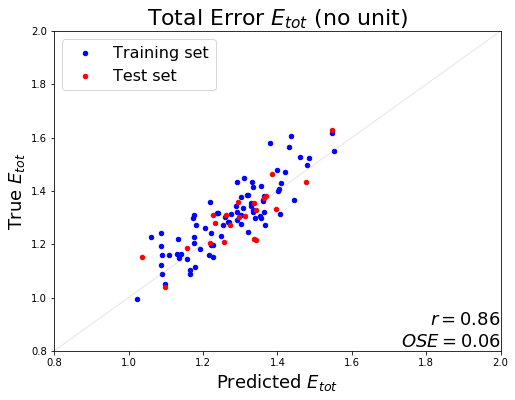

In [26]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"
Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.06$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.86$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.8,2)
plt.xlim(0.8,2)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [27]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

Fdbck_skill_eval = []
for i in X :
    tmp = em_fdb_std_skill_eval(80, i)
    Fdbck_skill_eval.append(tmp)

Validation_fdbck_df = pd.DataFrame()
Validation_fdbck_df['Fdbck_PPE'] = E_PPE_df['Fdbck']
Validation_fdbck_df['Fdbck_multilinreg_val'] = Fdbck_skill_eval
Validation_fdbck_df

,Fdbck_PPE,Fdbck_multilinreg_val
0,-0.825236,-1.180536
1,-1.659636,-1.594507
2,-1.215000,-1.068508
3,-1.321641,-1.363567
4,-0.750397,-1.140111
...,...,...
97,-1.516367,-1.550227
98,-1.584491,-1.635200
99,-1.474525,-1.418686
100,-1.445422,-1.621942


In [29]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_multilinreg_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_fdbck = sqrt(sum_diff/n)
OSE_fdbck

0.18506045695913942

In [31]:
r_test = np.corrcoef(Test_set_fdbck['Fdbck_multilinreg_val'], Test_set_fdbck['Fdbck_PPE'])
r_test

array([[1.        , 0.48017716],
       [0.48017716, 1.        ]])

In [32]:
r_full = np.corrcoef(Validation_fdbck_df['Fdbck_multilinreg_val'], Validation_fdbck_df['Fdbck_PPE'])
r_full

array([[1.       , 0.7259311],
       [0.7259311, 1.       ]])

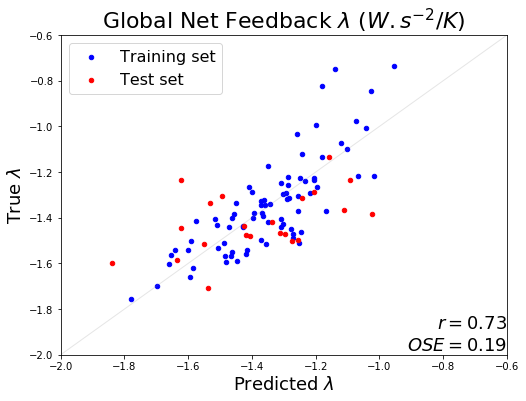

In [33]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.73$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.6)
plt.xlim(-2.0,-0.6)
ax.plot((-2.0,-0.6), (-2.0,-0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="init1">Step 2 - Initial guess for optimization 1</a> </li> 

In [21]:
E_multilinreg_df['members'] = range(0,len(E_multilinreg_df),1) 
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,budget_N,members
0,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694,-1.823649,0
1,-1.339351,2.081600,1.000683,2.608792,1.304885,2.090596,1.256180,1.822507,1.808354,1.342525,3.985243,1
2,-1.323732,2.055479,0.988126,2.371480,1.186184,1.715070,1.030537,1.608743,1.596250,1.200274,-9.405019,2
3,-1.541909,1.929926,0.927769,2.802809,1.401930,1.563995,0.939760,2.192307,2.175282,1.361185,-6.619939,3
4,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079,-0.710055,4
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,2.522046,1.212418,2.097249,1.049017,2.578970,1.549630,1.642064,1.629313,1.360094,6.891056,99995
99996,-1.410350,2.338067,1.123973,3.071470,1.536310,2.084024,1.252231,1.194517,1.185241,1.274439,-2.924478,99996
99997,-1.296397,1.954258,0.939466,2.422791,1.211849,1.277945,0.767881,1.656280,1.643418,1.140654,-8.546023,99997
99998,-1.299809,2.251847,1.082525,2.590714,1.295843,1.365484,0.820480,1.283676,1.273708,1.118139,-5.941461,99998


In [22]:
cpt=0
list_N=[]
for i in E_multilinreg_df['budget_N'] :
    if -2.0<i<2.0 : 
        list_N.append(cpt)
        cpt+=1
    else :
        cpt+=1

tmp_df=E_multilinreg_df.copy()
cpt=0
for j in list_N :
    tmp=E_multilinreg_df.iloc[j]
    tmp_df.iloc[cpt] = tmp
    cpt+=1
    
E_multilinreg_N_df=tmp_df.drop(range(cpt,len(E_multilinreg_df), 1))

E_multilinreg_N_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,budget_N,members
0,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694,-1.823649,0.0
1,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079,-0.710055,4.0
2,-1.107454,1.341275,0.644788,2.785019,1.393031,1.709112,1.026957,0.485382,0.481613,0.886597,0.237443,9.0
3,-1.377945,2.521338,1.212077,2.337479,1.169178,1.197899,0.719784,1.515722,1.503952,1.151248,-0.540774,15.0
4,-1.612530,2.099473,1.009275,2.890576,1.445830,2.314871,1.390940,1.569400,1.557213,1.350814,-0.809694,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20633,-1.645530,2.253918,1.083521,2.684819,1.342912,1.180309,0.709214,1.608092,1.595605,1.182813,1.620061,99962.0
20634,-1.432413,2.758727,1.326196,2.602333,1.301654,2.014783,1.210626,1.533581,1.521671,1.340037,1.031851,99965.0
20635,-1.233090,2.642719,1.270428,2.006858,1.003805,1.342676,0.806776,1.968041,1.952758,1.258442,0.030478,99968.0
20636,-1.245258,2.018014,0.970115,2.386096,1.193495,1.374123,0.825672,1.550732,1.538689,1.131993,-0.858940,99979.0


In [23]:
E_multilinreg_N_df['Fdbck_round'] = E_multilinreg_N_df['Fdbck'].round(decimals=2)
E_multilinreg_N_df = E_multilinreg_N_df.set_index('Fdbck_round')
E_multilinreg_N_df        

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,budget_N,members
Fdbck_round,,,,,,,,,,,,
-1.50,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694,-1.823649,0.0
-1.35,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079,-0.710055,4.0
-1.11,-1.107454,1.341275,0.644788,2.785019,1.393031,1.709112,1.026957,0.485382,0.481613,0.886597,0.237443,9.0
-1.38,-1.377945,2.521338,1.212077,2.337479,1.169178,1.197899,0.719784,1.515722,1.503952,1.151248,-0.540774,15.0
-1.61,-1.612530,2.099473,1.009275,2.890576,1.445830,2.314871,1.390940,1.569400,1.557213,1.350814,-0.809694,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
-1.65,-1.645530,2.253918,1.083521,2.684819,1.342912,1.180309,0.709214,1.608092,1.595605,1.182813,1.620061,99962.0
-1.43,-1.432413,2.758727,1.326196,2.602333,1.301654,2.014783,1.210626,1.533581,1.521671,1.340037,1.031851,99965.0
-1.23,-1.233090,2.642719,1.270428,2.006858,1.003805,1.342676,0.806776,1.968041,1.952758,1.258442,0.030478,99968.0


In [24]:
new_df=pd.DataFrame()
new_df['RMSE_total_best'] = E_multilinreg_N_df['RMSE_total'].groupby('Fdbck_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_round,RMSE_total_best
0,-1.90,1.566453
1,-1.89,1.499650
2,-1.87,1.409616
3,-1.86,1.488882
4,-1.85,1.314210
...,...,...
94,-0.95,0.992965
95,-0.94,1.036194
96,-0.93,0.985366
97,-0.92,1.214766


In [25]:
list_RMSE = new_df['RMSE_total_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_N_df['RMSE_total'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_N_df['Fdbck'].iloc[cpt])
            tmp_member.append(E_multilinreg_N_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_round,RMSE_total_best,Fdbck,members
0,-1.90,1.566453,-1.901409,94179.0
1,-1.89,1.499650,-1.893273,62476.0
2,-1.87,1.409616,-1.865100,47827.0
3,-1.86,1.488882,-1.855934,9061.0
4,-1.85,1.314210,-1.848024,45173.0
...,...,...,...,...
94,-0.95,0.992965,-0.949974,64992.0
95,-0.94,1.036194,-0.942374,28556.0
96,-0.93,0.985366,-0.926822,19875.0
97,-0.92,1.214766,-0.916210,88867.0


In [26]:
# CHECK OBJECTIVE FUNCTION

#x = x_best[4]
#y = function_RMSE_total(x, variables, E_p1_df)
#print(y)

### [Back to the top](#top)

# <a id="optim1">Step 3 - Optimization 1</a> </li> 

In [27]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[int(i)])

x_best=np.array(x_best)
#x_best

In [28]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [29]:
sol_df = Optimization(x_best, 0.01, xlim, variables, E_p1_df)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3455447295544358
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Iteration limit exceeded    (Exit mode 9)
            Current function value: 1.283526782174203
            Iterations: 101
            Function evaluations: 1063
            Gradient evaluations: 101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3400624696146193
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2639595820034395
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.250570203123652
            Iterations: 5
            Function evaluations: 19


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0028444521016628
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9711623566615079
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9722682472381265
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0323346464579992
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9336367248010433
            Iterations: 6
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.842821996950765
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.839602357965259
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8821487475614771
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8994086591826111
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8852179874504403
            Iterations: 2
            Function evaluatio

,sol_fun,Fdbck,budget_N,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.345545,-1.891409,1.997337,0.157830,0.687456,1.355265,20.304959,-0.010000,8.176275,0.253687,...,-2.689956,-31.173433,0.038452,18.506919,0.000010,0.730485,0.500000,0.717275,0.500000,7.824365
1,1.283527,-1.883273,-3.057293,0.172576,1.000957,1.491375,22.444165,-0.010000,3.687436,0.873634,...,-2.972708,-29.796876,0.067641,11.020457,0.000010,0.748964,0.606569,0.806619,0.500000,8.974818
2,1.340062,-1.855100,-1.995347,0.145529,0.777160,1.453246,11.486221,-0.058167,1.705305,9.725378,...,-4.406940,-26.962866,0.042067,15.879345,0.000010,0.703099,0.755406,0.662802,0.518352,1.156732
3,1.263960,-1.845935,-2.000000,0.145474,1.047368,1.357480,25.850464,-0.010000,5.247549,2.632656,...,-4.547936,-25.000000,0.065585,17.889383,0.000010,0.693964,0.500004,0.944963,0.500000,7.322933
4,1.250570,-1.838024,-2.000000,0.155714,0.627546,0.845156,14.721244,-0.010000,1.225412,6.247863,...,-4.197300,-39.290600,0.090176,14.734179,0.000010,0.628653,0.500000,0.781813,0.500000,2.391010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.914022,-0.943747,2.000000,0.205618,0.784586,0.862124,13.420765,-0.279668,3.762153,3.910185,...,-1.023498,-49.558493,0.010000,3.231955,0.000100,0.512899,0.507819,0.613317,0.664508,5.787156
95,0.861785,-0.945733,1.884050,0.171526,2.180619,0.944142,3.209864,-0.177920,1.188359,9.056667,...,-2.888217,-38.349261,0.017243,3.104324,0.000093,0.511738,0.762883,0.918100,0.596027,5.361682
96,0.902753,-0.933770,2.000000,0.222195,2.471943,0.533110,8.593526,-0.414175,2.255741,3.416286,...,-3.449464,-36.424639,0.010000,1.394244,0.000100,0.904527,0.544104,0.542289,0.615617,1.468210
97,0.917926,-0.923138,2.000000,0.176774,1.615474,1.839535,5.641318,-0.174618,2.071941,9.243012,...,-4.709984,-27.417110,0.010000,4.317685,0.000100,0.505267,0.521509,0.726171,0.525272,1.441256


### Plotting

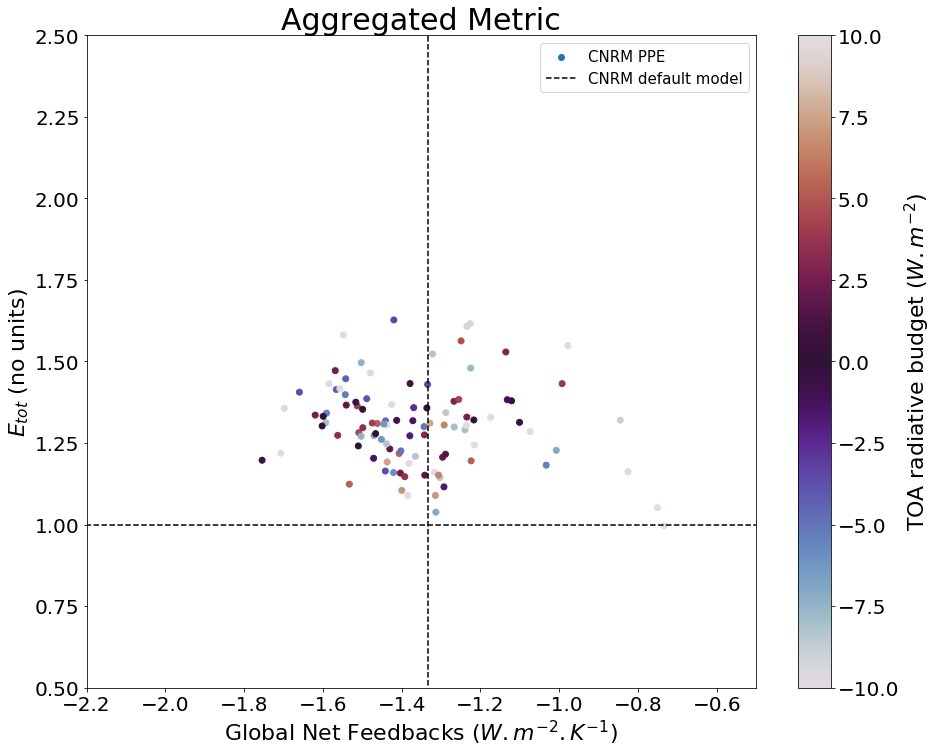

In [30]:
#ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)


#E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', colorbar=True, figsize=(15, 12), 
#                     marker="o", ax = ax)

fig = plt.figure(figsize=(15, 12))

cm = plt.cm.get_cmap('twilight')

sc = plt.scatter(E_PPE_df['Fdbck'], E_PPE_df['RMSE_total'], c=E_PPE_df['budget_N'], vmin=-10, vmax=10, 
            cmap=cm, marker="o")

cb = plt.colorbar(sc)
cb.set_label(label='TOA radiative budget ($W.m^{-2}$)',fontsize=22)

plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^{-2}.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title('Aggregated Metric', fontsize=30)
plt.tick_params(labelsize=20)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)

plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_only.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

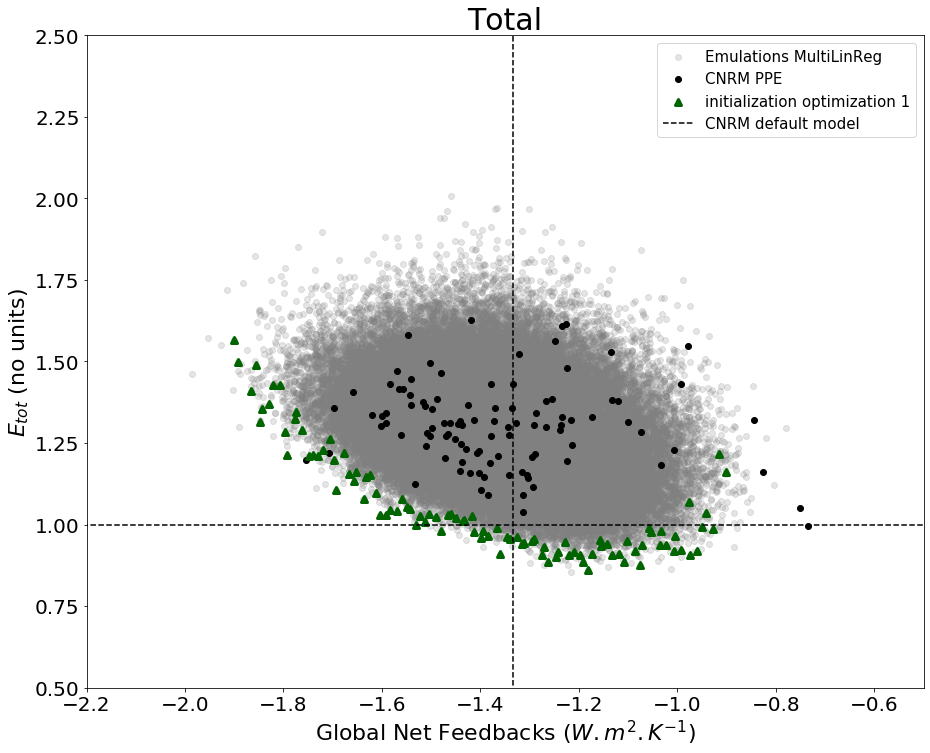

In [31]:
#ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

fig = plt.figure(figsize=(15, 12))

#E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
#                     marker="o", ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)


emul = plt.scatter(E_multilinreg_df['Fdbck'], E_multilinreg_df['RMSE_total'], color='gray', 
                 marker="o", alpha=0.2)

PPE = plt.scatter(E_PPE_df['Fdbck'], E_PPE_df['RMSE_total'],color='black', marker="o")

init = plt.scatter(new_df['Fdbck'], new_df['RMSE_total_best'], color='darkgreen', marker='^', linewidth=3, 
                   zorder=2)


plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Emulations MultiLinReg', 'CNRM PPE', 'initialization optimization 1', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
plt.tick_params(labelsize=20)

plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

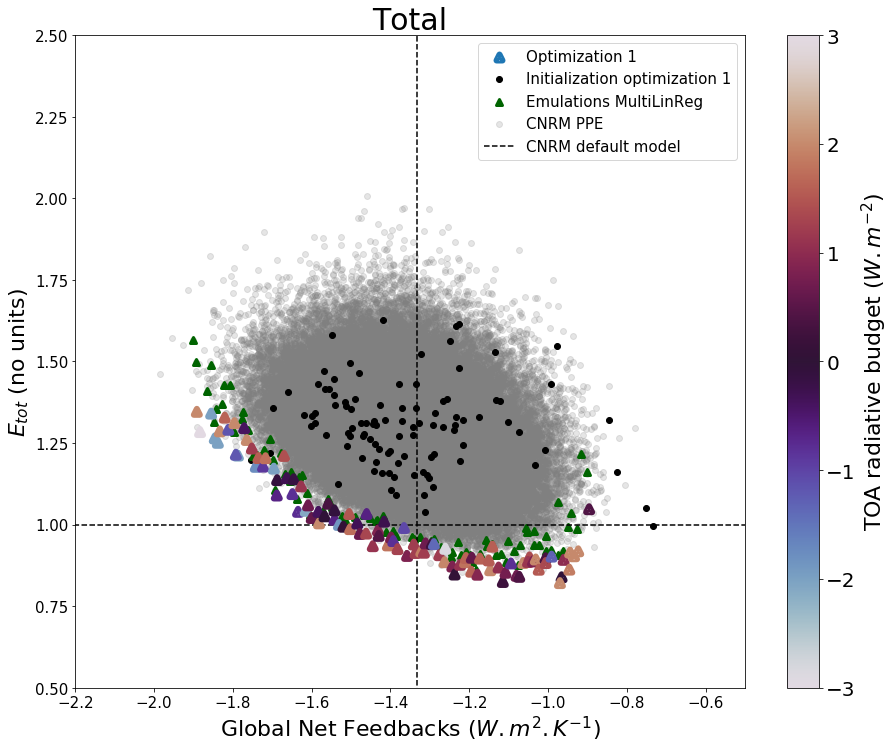

In [30]:
#ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

fig = plt.figure(figsize=(15, 12))

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'black', 
#         marker = '^', linewidth=6,  ax = ax)

cm = plt.cm.get_cmap('twilight') #twilight

sc = plt.scatter(sol_df['Fdbck'], sol_df['sol_fun'], c=sol_df['budget_N'], vmin=-3, vmax=3, 
            cmap=cm, marker="^", linewidth=6, zorder=3)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

PPE = plt.scatter(E_PPE_df['Fdbck'], E_PPE_df['RMSE_total'],color='black', marker="o", zorder=1)

init = plt.scatter(new_df['Fdbck'], new_df['RMSE_total_best'], color='darkgreen', marker='^', linewidth=3, 
                   zorder=2)

MLR = plt.scatter(E_multilinreg_df['Fdbck'], E_multilinreg_df['RMSE_total'], color='gray', 
                  alpha=0.2, marker='o', zorder=0)

cb = plt.colorbar(sc)
cb.set_label(label='TOA radiative budget ($W.m^{-2}$)',fontsize=22)

plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=15)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
        
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_N_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

#  <a id="init2">Step 4 - Initial guess for Optimization 2 (param. smoothing)</a> </li> 

In [31]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.891409,0.157830,0.687456,1.355265,20.304959,-0.010000,8.176275,0.253687,0.000500,0.001000,...,-2.689956,-31.173433,0.038452,18.506919,0.000010,0.730485,0.500000,0.717275,0.500000,7.824365
1,-1.883273,0.162128,0.866633,1.447816,19.169877,-0.022042,4.314113,2.931583,0.000500,0.000813,...,-2.757343,-31.459795,0.039230,18.099411,0.000011,0.735652,0.509879,0.722743,0.502510,7.405064
2,-1.855100,0.152277,0.900661,1.438837,17.816768,-0.034083,3.086399,5.739261,0.000500,0.000561,...,-2.823923,-31.743253,0.039993,17.695364,0.000012,0.740824,0.519659,0.728142,0.505035,6.991848
3,-1.845935,0.148048,0.874860,1.253341,19.477098,-0.022042,3.356454,5.309638,0.000500,0.000215,...,-2.888909,-32.020835,0.040724,17.298137,0.000013,0.746002,0.529247,0.733404,0.507587,6.590559
4,-1.838024,0.138263,0.733730,1.240120,14.573890,-0.040125,2.402811,4.115342,0.000500,0.000288,...,-2.951550,-32.289451,0.041411,16.910893,0.000013,0.751183,0.538556,0.738470,0.510180,6.206562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,-0.943747,0.191379,1.302899,0.832322,10.207281,-0.246640,2.671776,4.752980,0.004223,0.000280,...,-3.476350,-43.526860,0.011522,5.950125,0.000092,0.653643,0.566683,0.660932,0.677491,6.866609
95,-0.945733,0.192716,1.904442,0.820880,7.108505,-0.262421,2.098653,6.359951,0.004727,0.000224,...,-3.566944,-44.116304,0.011150,6.310224,0.000092,0.651210,0.560827,0.640255,0.681601,7.224950
96,-0.933770,0.198172,2.184995,0.962474,6.509558,-0.295222,1.942945,6.283063,0.004422,0.000319,...,-3.661291,-44.737408,0.010771,6.687765,0.000093,0.648780,0.554731,0.618874,0.685699,7.595186
97,-0.923138,0.185052,2.093280,1.281677,7.356599,-0.264314,2.151704,5.713078,0.004878,0.000475,...,-3.758226,-45.380465,0.010387,7.077327,0.000094,0.646351,0.548469,0.597011,0.689783,7.973607


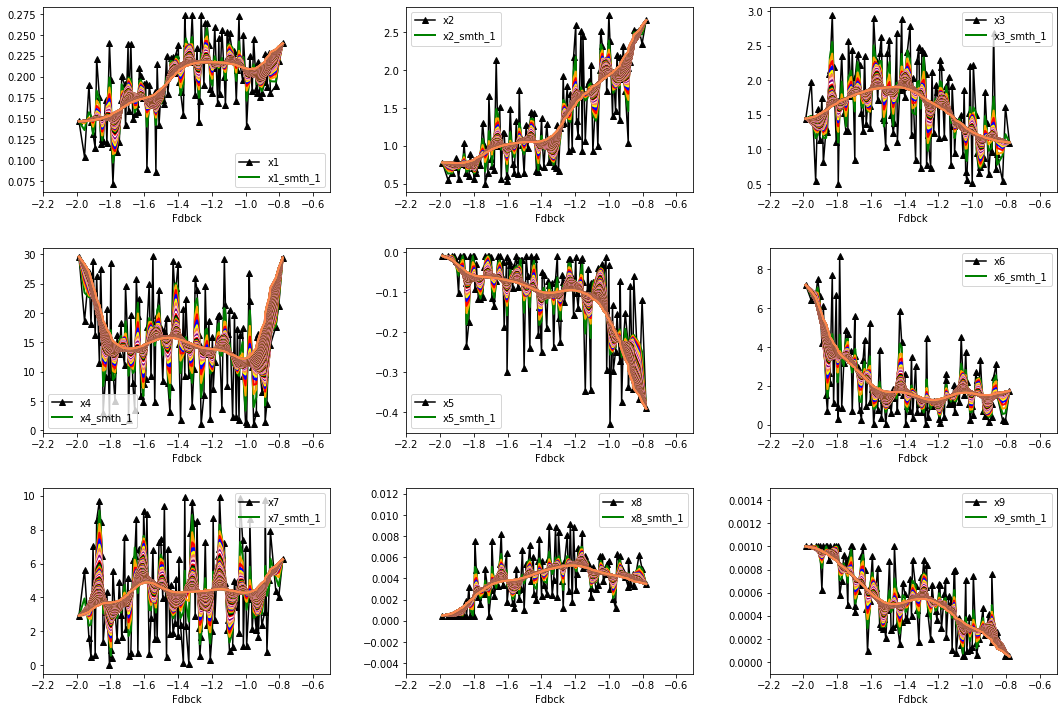

In [32]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

# <a id="optim2">Step 5 - Optimisation 2</a> </li> 

In [35]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.15782969, 0.68745562, 1.35526546, ..., 0.71727503, 0.5       ,
        7.82436475],
       [0.15602748, 0.70540831, 1.35861661, ..., 0.72274337, 0.5025102 ,
        7.4050637 ],
       [0.15427624, 0.72326685, 1.36194853, ..., 0.72814166, 0.5050347 ,
        6.99184815],
       ...,
       [0.16819282, 2.49128536, 1.00482562, ..., 0.61887421, 0.68569852,
        7.59518644],
       [0.16633884, 2.58026831, 0.95978585, ..., 0.59701113, 0.68978347,
        7.97360679],
       [0.16446731, 2.67022887, 0.91452804, ..., 0.57490251, 0.69386121,
        8.35619774]])

In [36]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_total(i, variables, E_p1_df)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.891409,1.345545
1,-1.883273,1.329217
2,-1.855100,1.313428
3,-1.845935,1.298261
4,-1.838024,1.283764
...,...,...
94,-0.943747,0.945180
95,-0.945733,0.967261
96,-0.933770,0.991750
97,-0.923138,1.018419


In [37]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variables, E_p1_df)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3409397428670855
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3292175517771834
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.31342847167986
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2982607687409833
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2837638937596019
            Iterations: 1
            Function evaluatio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9650887461701747
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9598976586596895
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9547864018403296
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9497469073587033
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9447754349032326
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8408767330091292
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8411479012402754
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8418852333990905
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8431924960772905
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8451952646797481
            Iterations: 1
            Function evaluat

,sol_fun,Fdbck,budget_N,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.340940,-1.891309,1.975305,0.142743,0.682049,1.269542,20.273421,-0.010000,7.936192,0.235893,...,-2.679629,-31.151706,0.040312,18.376425,0.000010,0.722566,0.500000,0.732601,0.500000,7.747924
1,1.329218,-1.880527,1.805066,0.156024,0.705407,1.358600,19.745004,-0.013383,7.808501,0.568420,...,-2.757340,-31.459791,0.039230,18.099386,0.000011,0.735650,0.509874,0.722746,0.502509,7.405049
2,1.313428,-1.869659,1.615506,0.154276,0.723267,1.361946,19.190001,-0.016749,7.444906,0.879561,...,-2.823922,-31.743252,0.039993,17.695360,0.000012,0.740824,0.519658,0.728142,0.505034,6.991846
3,1.298261,-1.858819,1.431420,0.152625,0.740937,1.365245,18.644739,-0.020074,7.089266,1.183641,...,-2.888909,-32.020835,0.040724,17.298137,0.000013,0.746002,0.529247,0.733404,0.507587,6.590559
4,1.283764,-1.848018,1.255210,0.151121,0.758327,1.368497,18.113766,-0.023341,6.745124,1.477471,...,-2.951550,-32.289451,0.041411,16.910893,0.000013,0.751183,0.538556,0.738470,0.510180,6.206562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.929474,-0.939818,0.909894,0.171799,2.310549,1.086997,10.233465,-0.256944,1.903062,2.091284,...,-3.475190,-43.523930,0.011210,5.947145,0.000093,0.652904,0.562945,0.662666,0.672721,6.860505
95,0.952472,-0.928813,0.810964,0.171105,2.240786,0.962159,10.040146,-0.216163,1.804519,1.798172,...,-3.546138,-44.064160,0.010815,6.254292,0.000095,0.639151,0.546520,0.670690,0.642623,7.117072
96,0.978324,-0.917731,0.580267,0.168307,2.485149,1.001246,9.905639,-0.274751,2.050861,1.541264,...,-3.660560,-44.735599,0.010679,6.685702,0.000094,0.648355,0.552552,0.619954,0.682790,7.591463
97,1.002453,-0.906632,0.496647,0.166532,2.572933,0.955802,9.728995,-0.282121,2.124483,1.247745,...,-3.757367,-45.378358,0.010333,7.074794,0.000095,0.645875,0.545959,0.598273,0.686413,7.969297


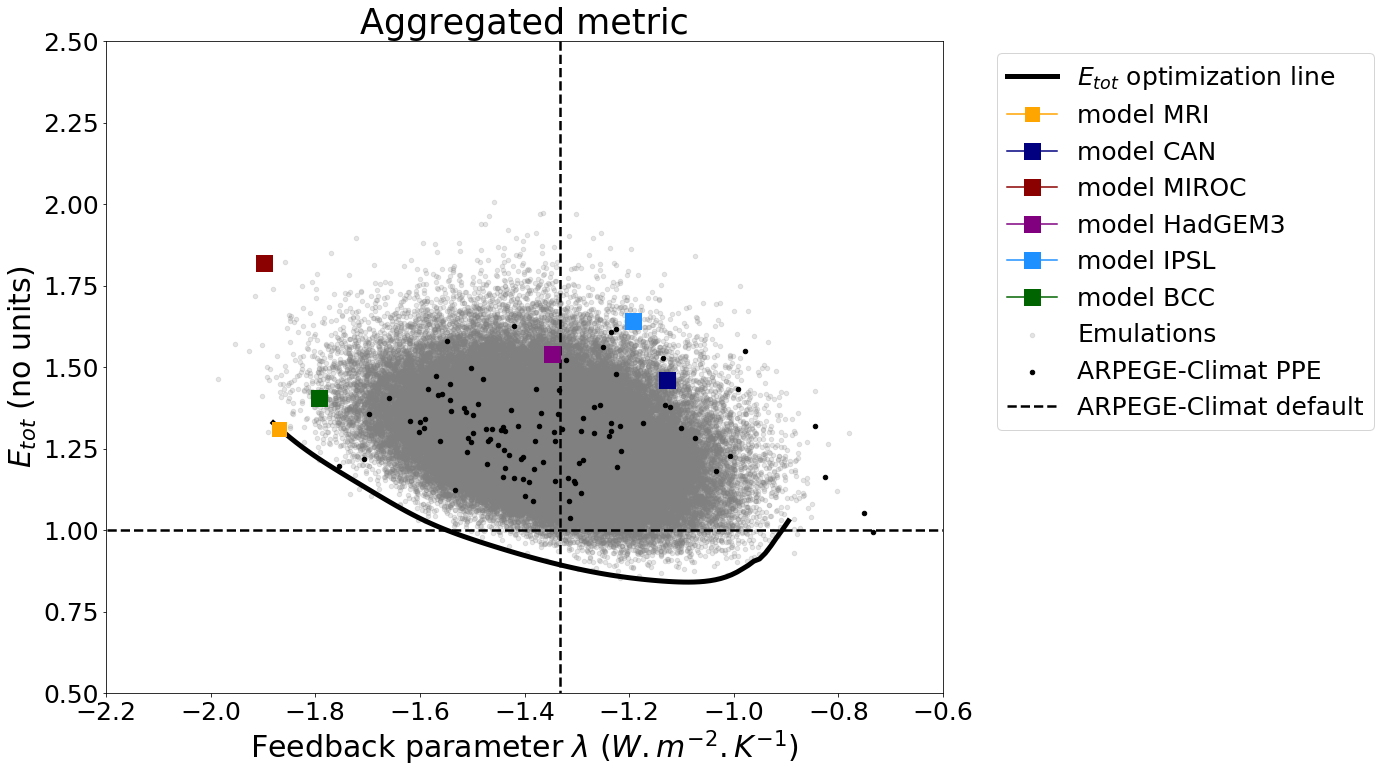

In [38]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{tot}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title('Aggregated metric', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_N_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

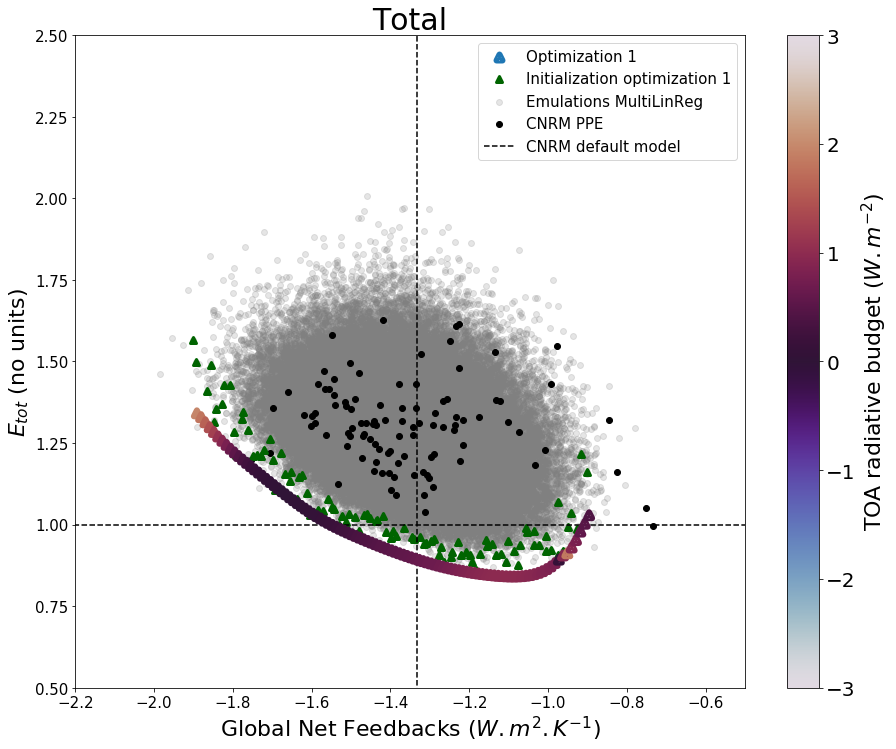

In [46]:
#ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

fig = plt.figure(figsize=(15, 12))

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'black', 
#         marker = '^', linewidth=6,  ax = ax)

cm = plt.cm.get_cmap('twilight') #twilight

sc = plt.scatter(sol_df_2['Fdbck'], sol_df_2['sol_fun'], c=sol_df_2['budget_N'], vmin=-3, vmax=3, 
            cmap=cm, marker="^", linewidth=6, zorder=3)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

init = plt.scatter(new_df['Fdbck'], new_df['RMSE_total_best'], color='darkgreen', marker='^', linewidth=3, 
                   zorder=2)

MLR = plt.scatter(E_multilinreg_df['Fdbck'], E_multilinreg_df['RMSE_total'], color='gray', 
                  alpha=0.2, marker='o', zorder=0)

PPE = plt.scatter(E_PPE_df['Fdbck'], E_PPE_df['RMSE_total'],color='black', marker="o", zorder=1)

cb = plt.colorbar(sc)
cb.set_label(label='TOA radiative budget ($W.m^{-2}$)',fontsize=22)

plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=15)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
        
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_N_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [47]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_'+variable_plot+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_N_optim2_'+variable_plot+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

In [48]:
df_select = sol_df_2[sol_df_2.index % 15 == 0]
df_select = df_select.append(sol_df_2.iloc[len(sol_df_2)-1])
df_select

,sol_fun,Fdbck,budget_N,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.340940,-1.891309,1.975305,0.142743,0.682049,1.269542,20.273421,-0.010000,7.936192,0.235893,...,-2.679629,-31.151706,0.040312,18.376425,0.000010,0.722566,0.500000,0.732601,0.500000,7.747924
15,1.159234,-1.733555,0.131083,0.150813,0.907104,1.408639,14.097018,-0.053287,4.086708,3.597659,...,-3.337509,-33.752035,0.044939,13.831231,0.000025,0.799749,0.613447,0.775526,0.542377,3.802492
30,1.025745,-1.585977,0.105363,0.172274,0.974750,1.530321,14.795624,-0.082687,2.111961,4.554154,...,-2.874061,-32.038837,0.045174,11.418158,0.000043,0.797010,0.672242,0.798534,0.579378,3.187097
45,0.939872,-1.436926,0.466902,0.191214,1.092232,1.614743,14.800644,-0.098420,1.582139,4.924774,...,-2.663939,-33.707640,0.041629,8.020574,0.000061,0.747490,0.650754,0.810096,0.598612,2.570843
60,0.877438,-1.286299,0.682172,0.197421,1.322389,1.556444,13.379449,-0.098353,1.800013,4.510824,...,-3.151299,-35.766424,0.027692,6.152405,0.000072,0.756759,0.620506,0.826181,0.612765,3.113257
75,0.844079,-1.136180,0.977751,0.191596,1.555623,1.499737,11.892128,-0.141744,1.556942,3.764802,...,-2.891035,-39.036439,0.018002,4.060010,0.000080,0.709557,0.611884,0.834115,0.629358,3.707079
90,0.881818,-0.983110,0.795331,0.178149,2.024379,1.256557,10.737835,-0.232814,1.668508,2.946810,...,-3.169191,-41.622809,0.012915,4.766188,0.000089,0.663496,0.586552,0.733121,0.661130,5.609739
98,1.028489,-0.895516,0.401185,0.164758,2.661569,0.910145,9.548672,-0.289493,2.198822,0.948848,...,-3.855482,-46.032330,0.010000,7.469956,0.000095,0.643394,0.539280,0.576363,0.690001,8.351263


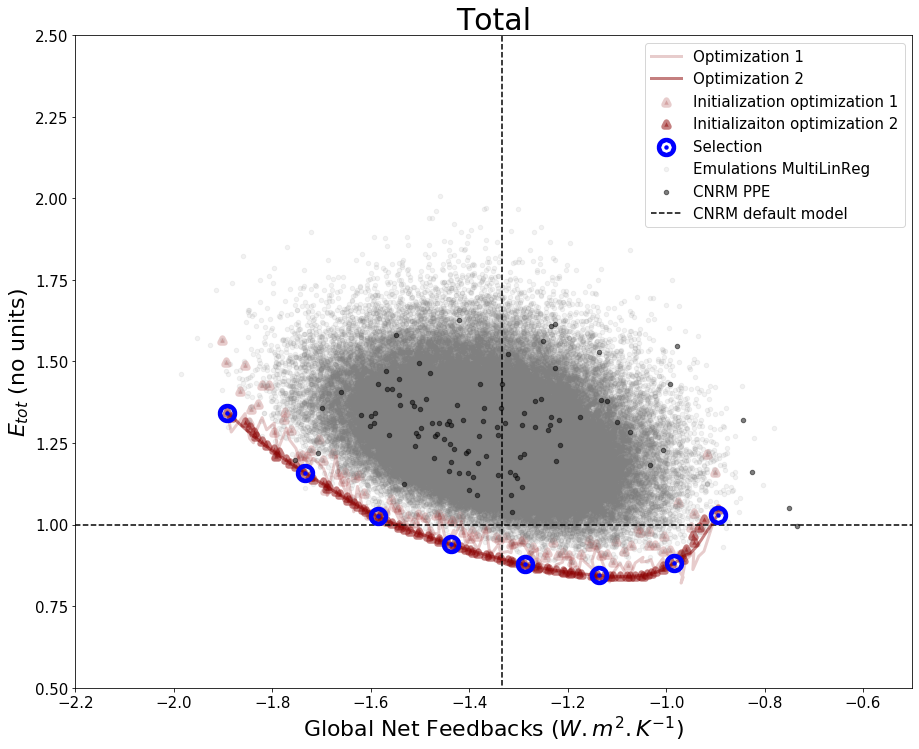

In [49]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_N_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [50]:
list_index = df_select.columns.tolist()
list_index

['sol_fun',
 'Fdbck',
 'budget_N',
 'x1_smth_0',
 'x2_smth_0',
 'x3_smth_0',
 'x4_smth_0',
 'x5_smth_0',
 'x6_smth_0',
 'x7_smth_0',
 'x8_smth_0',
 'x9_smth_0',
 'x10_smth_0',
 'x11_smth_0',
 'x12_smth_0',
 'x13_smth_0',
 'x14_smth_0',
 'x15_smth_0',
 'x16_smth_0',
 'x17_smth_0',
 'x18_smth_0',
 'x19_smth_0',
 'x20_smth_0',
 'x21_smth_0',
 'x22_smth_0',
 'x23_smth_0',
 'x24_smth_0',
 'x25_smth_0',
 'x26_smth_0',
 'x27_smth_0',
 'x28_smth_0',
 'x29_smth_0',
 'x30_smth_0']

### Save the data

In [51]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_select.npy', df_select)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_select_indexes.npy', list_index)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_total.npy', sol_df_2)

In [52]:
df_select_tmp = df_select.drop(['sol_fun', 'Fdbck', 'budget_N'], axis=1)

#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_BIS_optim2_param.txt', df_select_tmp.values)
np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_N_optim2_param.txt', df_select_tmp.values)

### [Back to the top](#top)

# <a id="validation">Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3</a> </li>

### Settings

In [1]:
nb_p_list_selection = ['p830', 'p831', 'p832', 'p833','p834', 'p835']
len(nb_p_list_selection)

6

In [26]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_select.npy')
df_select = pd.DataFrame(file).drop([6,7])
df_select['sol_fun'] = df_select[0]
df_select['Fdbck'] = df_select[1]
df_select = df_select
df_select

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,sol_fun,Fdbck
0,1.340940,-1.891309,1.975305,0.142743,0.682049,1.269542,20.273421,-0.010000,7.936192,0.235893,...,0.040312,18.376425,0.000010,0.722566,0.500000,0.732601,0.500000,7.747924,1.340940,-1.891309
1,1.159234,-1.733555,0.131083,0.150813,0.907104,1.408639,14.097018,-0.053287,4.086708,3.597659,...,0.044939,13.831231,0.000025,0.799749,0.613447,0.775526,0.542377,3.802492,1.159234,-1.733555
2,1.025745,-1.585977,0.105363,0.172274,0.974750,1.530321,14.795624,-0.082687,2.111961,4.554154,...,0.045174,11.418158,0.000043,0.797010,0.672242,0.798534,0.579378,3.187097,1.025745,-1.585977
3,0.939872,-1.436926,0.466902,0.191214,1.092232,1.614743,14.800644,-0.098420,1.582139,4.924774,...,0.041629,8.020574,0.000061,0.747490,0.650754,0.810096,0.598612,2.570843,0.939872,-1.436926
4,0.877438,-1.286299,0.682172,0.197421,1.322389,1.556444,13.379449,-0.098353,1.800013,4.510824,...,0.027692,6.152405,0.000072,0.756759,0.620506,0.826181,0.612765,3.113257,0.877438,-1.286299
5,0.844079,-1.136180,0.977751,0.191596,1.555623,1.499737,11.892128,-0.141744,1.556942,3.764802,...,0.018002,4.060010,0.000080,0.709557,0.611884,0.834115,0.629358,3.707079,0.844079,-1.136180


In [27]:
df_crashed = pd.DataFrame(file).drop([0,1,2,3,4,5])
df_crashed['sol_fun']=df_crashed[0]
df_crashed['Fdbck']=df_crashed[1]
df_crashed

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,sol_fun,Fdbck
6,0.881818,-0.983110,0.795331,0.178149,2.024379,1.256557,10.737835,-0.232814,1.668508,2.946810,...,0.012915,4.766188,0.000089,0.663496,0.586552,0.733121,0.661130,5.609739,0.881818,-0.983110
7,1.028489,-0.895516,0.401185,0.164758,2.661569,0.910145,9.548672,-0.289493,2.198822,0.948848,...,0.010000,7.469956,0.000095,0.643394,0.539280,0.576363,0.690001,8.351263,1.028489,-0.895516


In [28]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_N_optim2_'+variable_plot+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_N_optim2_'+variable_plot+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,sol_fun,Fdbck
0,1.340940,-1.891309,1.975305,0.142743,0.682049,1.269542,20.273421,-0.010000,7.936192,0.235893,...,0.040312,18.376425,0.000010,0.722566,0.500000,0.732601,0.500000,7.747924,1.340940,-1.891309
1,1.329218,-1.880527,1.805066,0.156024,0.705407,1.358600,19.745004,-0.013383,7.808501,0.568420,...,0.039230,18.099386,0.000011,0.735650,0.509874,0.722746,0.502509,7.405049,1.329218,-1.880527
2,1.313428,-1.869659,1.615506,0.154276,0.723267,1.361946,19.190001,-0.016749,7.444906,0.879561,...,0.039993,17.695360,0.000012,0.740824,0.519658,0.728142,0.505034,6.991846,1.313428,-1.869659
3,1.298261,-1.858819,1.431420,0.152625,0.740937,1.365245,18.644739,-0.020074,7.089266,1.183641,...,0.040724,17.298137,0.000013,0.746002,0.529247,0.733404,0.507587,6.590559,1.298261,-1.858819
4,1.283764,-1.848018,1.255210,0.151121,0.758327,1.368497,18.113766,-0.023341,6.745124,1.477471,...,0.041411,16.910893,0.000013,0.751183,0.538556,0.738470,0.510180,6.206562,1.283764,-1.848018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.929474,-0.939818,0.909894,0.171799,2.310549,1.086997,10.233465,-0.256944,1.903062,2.091284,...,0.011210,5.947145,0.000093,0.652904,0.562945,0.662666,0.672721,6.860505,0.929474,-0.939818
95,0.952472,-0.928813,0.810964,0.171105,2.240786,0.962159,10.040146,-0.216163,1.804519,1.798172,...,0.010815,6.254292,0.000095,0.639151,0.546520,0.670690,0.642623,7.117072,0.952472,-0.928813
96,0.978324,-0.917731,0.580267,0.168307,2.485149,1.001246,9.905639,-0.274751,2.050861,1.541264,...,0.010679,6.685702,0.000094,0.648355,0.552552,0.619954,0.682790,7.591463,0.978324,-0.917731
97,1.002453,-0.906632,0.496647,0.166532,2.572933,0.955802,9.728995,-0.282121,2.124483,1.247745,...,0.010333,7.074794,0.000095,0.645875,0.545959,0.598273,0.686413,7.969297,1.002453,-0.906632


### Error estimate

In [29]:
PC_PPE_selection = {}

for j in variables :
    for i in nb_p_list_selection :
        PC_PPE_selection[i+'_'+j] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+j+'.npy')
    
PC_PPE_selection

{'p830_tas': array([ 1.2136192, -0.6098294,  1.9897791, -1.6556445,  0.8839032],
       dtype=float32),
 'p831_tas': array([ 1.0120285, -1.0892862,  0.9767731, -0.479844 ,  0.7853311],
       dtype=float32),
 'p832_tas': array([ 0.8543407 , -0.9796179 ,  0.32075801,  0.1599607 ,  1.1866205 ],
       dtype=float32),
 'p833_tas': array([ 0.5299683 , -0.13121139,  0.25907466,  0.94177157,  2.2121    ],
       dtype=float32),
 'p834_tas': array([ 0.20738026, -0.55950236, -0.6820719 ,  1.0935107 ,  1.6499455 ],
       dtype=float32),
 'p835_tas': array([ 0.39946637, -1.1224369 , -0.48563376,  0.5891387 ,  1.6797179 ],
       dtype=float32),
 'p830_pr': array([2.19761649, 0.19068962, 1.6599782 , 1.21034009, 1.5614902 ]),
 'p831_pr': array([ 1.0846325 ,  0.56347066,  0.23607759, -0.25507645,  2.6713772 ]),
 'p832_pr': array([ 0.54839645,  0.73120432, -0.46684798, -0.08666808,  1.55854614]),
 'p833_pr': array([ 0.50388758, -0.29914771, -0.21229804, -1.27732825,  2.10345011]),
 'p834_pr': array

In [30]:
E_PPE_selection = {}

for j in variables :
    list_tmp = []
    for i in nb_p_list_selection :
        pc1 = PC_PPE_selection[i+'_'+j][0]
        pc2 = PC_PPE_selection[i+'_'+j][1]
        pc3 = PC_PPE_selection[i+'_'+j][2]
        pc4 = PC_PPE_selection[i+'_'+j][3]
        pc5 = PC_PPE_selection[i+'_'+j][4]
    
        list_tmp.append(Error_emulator(pc1, pc2, pc3, pc4, pc5, j))
    E_PPE_selection[j] = list_tmp

E_PPE_selection

{'tas': [2.2578705059248954,
  1.7752828379837209,
  1.4199673548158247,
  1.0012093976480032,
  1.0974588115870967,
  1.091641155125766],
 'pr': [2.951959118790733,
  3.264533876625693,
  2.738526734855304,
  3.3521022266406413,
  2.2039248172238333,
  2.3766166200053567],
 'SW': [1.5742404377697774,
  1.2164097346757676,
  1.0911331498353247,
  1.356953091179851,
  0.9316907512368079,
  1.104173391339863],
 'LW': [1.5704016580016247,
  1.5960924248766604,
  1.6008580667322072,
  1.0726491862893073,
  1.1167108123067395,
  1.0081543803571935]}

In [31]:
E_PPE_selection_total=[0]*len(E_PPE_selection['tas'])

for i in range(0,len(E_PPE_selection['tas']),1) :
    E_PPE_selection_total[i] = E_PPE_selection['tas'][i]/E_p1_df['E_p1_tas']+E_PPE_selection['pr'][i]/E_p1_df['E_p1_pr']+E_PPE_selection['SW'][i]/E_p1_df['E_p1_SW']+E_PPE_selection['LW'][i]/E_p1_df['E_p1_LW']
    E_PPE_selection_total[i] = E_PPE_selection_total[i]/4

E_PPE_selection_total

[1.2665191762924,
 1.200227583071662,
 1.0741129203977733,
 1.0094156124172886,
 0.8244549368960641,
 0.8443319479078868]

In [32]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/Net_feedbacks_optimN.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.6648834149042766,
 -1.6828059355417888,
 -1.6632171869277954,
 -1.5863710641860962,
 -1.3997870286305745,
 -1.0025604963302612]

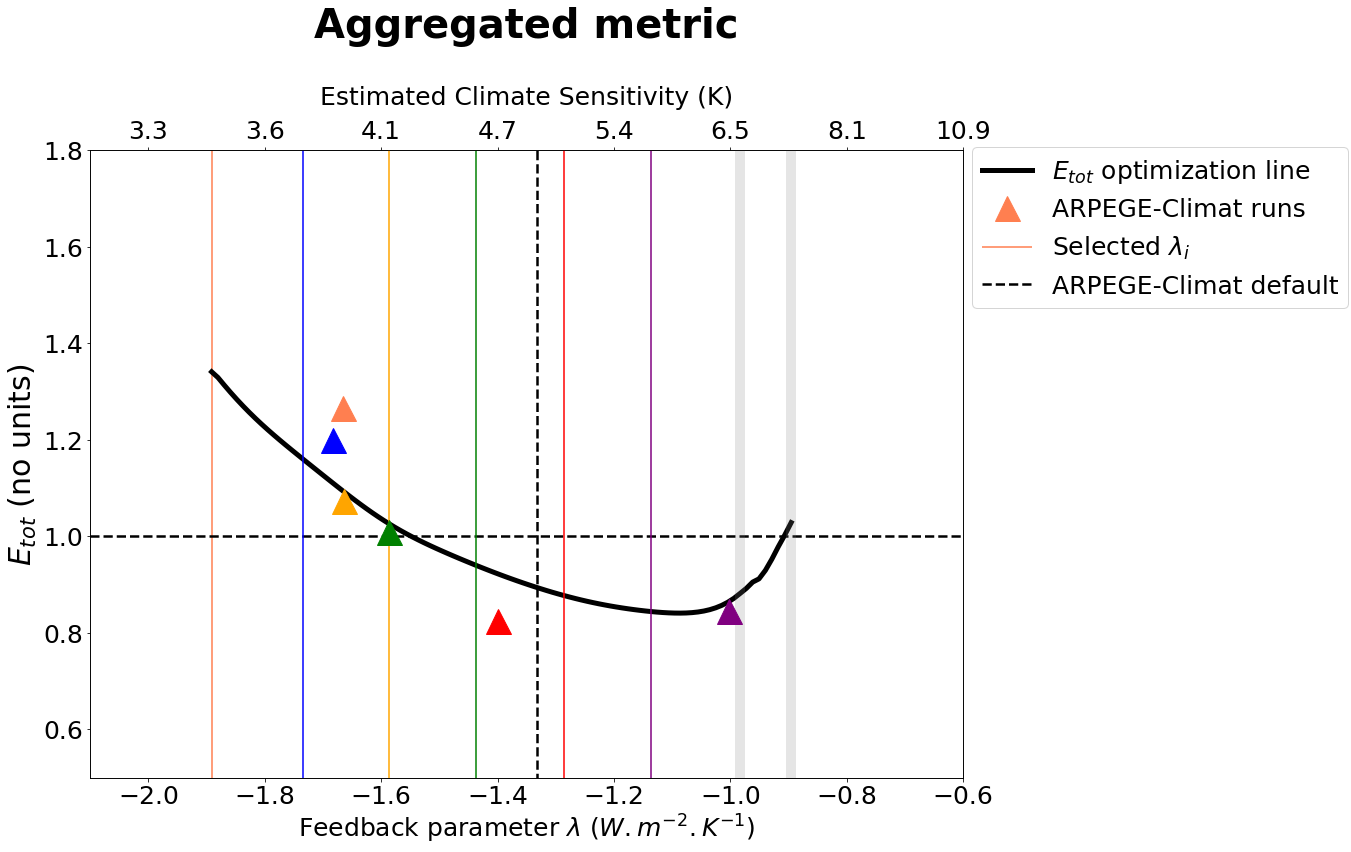

In [34]:
colors = ['coral', 'blue','orange','green','red','purple']
cpt=0

fig = plt.figure(figsize=(14, 12))
ax = plt.gca()
ax2 = ax.twiny()

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)


for i in colors :
    if cpt == 0 :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)
        ax.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, label='$\lambda$ selection',
           linestyles='solid', linewidth=1.5)

        ax.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', linewidth=0, 
                        label='ARPEGE-Climat simulations', markersize=25, zorder=10)
        cpt+=1
    else :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')
        plt.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, 
           linestyles='solid', linewidth=1.5)
        
        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', 
                 linewidth=0, markersize=25, label='_nolegend_', zorder=10)
        cpt+=1

plt.vlines(df_crashed['Fdbck'].iloc[0],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)
plt.vlines(df_crashed['Fdbck'].iloc[1],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)

ax.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='ARPEGE-Climat default', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
        
ax.set_xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=25)
ax.set_ylabel(ylabel, fontsize=30)
ax.set_xlim(-2.1,-0.6)

plt.title('Aggregated metric', fontsize=40, fontweight='bold', y=1.17)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.ylim(0.5,1.6)
#plt.xlim(-2.2,-0.6)

# Second axis

new_tick_locations = np.array([-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6])#df_select['Fdbck'])

def tick_function(X):
    V = -6.517/X
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Estimated Climate Sensitivity (K)", fontsize=25, labelpad=15.0)
ax2.tick_params(axis='both', which='major', labelsize=25)

plt.ylim(0.5,1.8)
#plt.xlim(-2.2,-0.6)

# Legend

legend = [ '$E_{tot}$ optimization line','ARPEGE-Climat runs','Selected $\lambda_i$', 'ARPEGE-Climat default']
ax.get_legend().remove()
fig.legend(legend, fontsize=25, bbox_to_anchor=(1.35, 0.83)) #bbox_to_anchor=(1.05, 1)
fig.subplots_adjust(right=0.8)

plt.tight_layout()

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optimN_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [68]:
df_RMSE_selection = pd.DataFrame(E_PPE_selection_total, columns=['E_arpege'])
df_RMSE_selection['E_multilinreg'] = df_select['sol_fun'].data

df_fdbck_selection = pd.DataFrame(Fdbck_PPE_selection, columns=['fdbck_arpege'])
df_fdbck_selection['fdbck_multilinreg'] = df_select['Fdbck'].data
df_fdbck_selection

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


,fdbck_arpege,fdbck_multilinreg
0,-1.781610,-1.985856
1,-1.667639,-1.639310
2,-1.559913,-1.490135
3,-1.435194,-1.339147
4,-1.059083,-1.188858
5,-0.704648,-1.039423
6,-0.643735,-0.873522


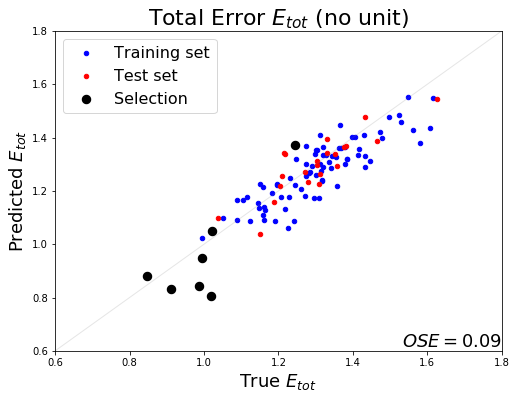

In [69]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"

Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='red',  
                     marker="o", ax = ax)

df_RMSE_selection.plot(kind='scatter', x='E_arpege', y='E_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.09$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set','Test set','Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.6,1.8)
plt.xlim(0.6,1.8)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

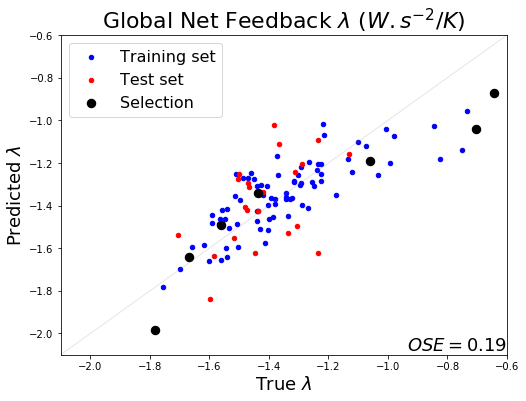

In [70]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)
df_fdbck_selection.plot(kind='scatter', x='fdbck_arpege', y='fdbck_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set', 'Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.1,-0.6)
plt.xlim(-2.1,-0.6)
ax.plot((-4.0,0.6), (-4.0,0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# Retour aux paramètres

In [ ]:
param_names = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy')
E_emulator_df = E_multilinreg_df.reset_index()

x_emulator = pd.DataFrame(LHS, columns= param_names)
x_emulator['RMSE_total'] = E_emulator_df['RMSE_total']

x_emulator['RMSE_total_round'] = x_emulator['RMSE_total'].round(decimals=1)
x_emulator['members'] = range(0,100000,1) 

#x_emulator = x_emulator.set_index('RMSE_total_round')
#x_emulator_new_df=pd.DataFrame()
#x_emulator_new_df['RMSE_total_best'] = x_emulator['RMSE_total'].groupby('RMSE_total_round').min()
#x_emulator_new_df = x_emulator_new_df.reset_index()
#x_emulator_new_df

In [ ]:
x_emulator

In [ ]:
x_init1 = pd.DataFrame(x_best, columns=[i+'_init1' for i in param_names])
x_init1['members'] = range(0, len(x_init1), 1)
x_init1 = x_init1.set_index('members')

#x_init1

x_optim1 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim1[param_names[i]+'_optim1'] = sol_df['x'+str(j)+'_smth_0']
x_optim1['members'] = range(0, len(x_init1), 1)
x_optim1 = x_optim1.set_index('members')
#x_optim1

x_init2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_init2[param_names[i]+'_init2'] = new_sol_df['x'+str(j)+'_smth_150']
x_init2['members'] = range(0, len(x_init1), 1)
x_init2 = x_init2.set_index('members')
#x_init2

x_optim2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim2[param_names[i]+'_optim2'] = sol_df_2['x'+str(j)+'_smth_0']
x_optim2['members'] = range(0, len(x_init1), 1)
x_optim2 = x_optim2.set_index('members')
#x_optim2

X = x_init1.merge(x_optim1, on = ['members']).merge(x_init2, on = ['members']).merge(x_optim2, on = ['members'])
X['Fdbck'] = sol_df_2['Fdbck']
X

In [ ]:
sol_df_2['RMSE'] = sol_df_2['sol_fun'].round(decimals=2)
sol_df_2

In [ ]:
def plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax):
    
    sns.scatterplot(data=df, x="Fdbck", y=param_y+'_smth_0', hue=hue, legend = 'full', palette=colors, ax=ax)
    
    plt.plot(p1_feedbacks, p1_params[ylabel], color='black', marker='+', linewidth=0, markersize=50)
    
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    #plt.legend(legend, fontsize=15)
    #plt.title('Param 1 et 2', fontsize=30)
    #ax.legend([None])
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-2.2,-0.5) 
    ind = df[param_y+'_smth_0'].max() - df[param_y+'_smth_0'].min()
    if p1_params[ylabel]<df[param_y+'_smth_0'].min() :
        lim_min = p1_params[ylabel]
    else :
        lim_min = df[param_y+'_smth_0'].min()
    
    if p1_params[ylabel]>df[param_y+'_smth_0'].max() :
        lim_max = p1_params[ylabel]
    else :
        lim_max = df[param_y+'_smth_0'].max()
        
    plt.ylim(lim_min-ind/10,lim_max+ind/10)

    # Show la figure .................
    #plt.show()

In [ ]:
# READ FROM ROMAIN REF NAMELIST 

p1_params = {}
p1_params['AKN'] = 0.126
p1_params['ALPHAT'] = 1.13
p1_params['ALD'] = 1.18
p1_params['ALMAVE'] = 10.0
p1_params['AGREF'] = -0.36
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0002
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.00006
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params', p1_params)
#p1_params

In [ ]:
df=sol_df_2
hue = df['RMSE']
legend = df['RMSE']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')

plt.subplots(figsize=(25,25)) 
ax={}

for i in range(0, 30, 1) :
    
    plt.subplot(6,5,(i+1))
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax[str(i)])
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 7.5), loc=2)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()